# Bilateral Bargaining: Evaluation of the Experiments

In [1]:
import os
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import pandas as pd

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'bnelearn'))

from bnelearn.util.metrics import ALIASES_LATEX
from scripts.utils import *

In [2]:
### EXP-1 BB 1/2-DA & VCG -----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-1_experiment-v2'

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-1_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the two most common mechanisms in the bilateral bargaining setup. For the average double auction, we only compare the learned strategies to the payoff dominant equilibrium strategies.",
    symmetric = False,
    label = 'tab:exp-1_table'
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kohring/bnelearn/experiments/debug/exp-1_experiment-v2/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'

In [3]:
def get_value_and_std_from_df_entry(df_entry: str) -> float:
    list_of_numbers = re.findall('\d+', df_entry)
    return float(list_of_numbers[0] + '.' + list_of_numbers[1]), float(list_of_numbers[2] + '.' + list_of_numbers[3])

In [ ]:
### EXP-2 risk experiments ----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-2_experiment-v2'
path += '/double_auction/single_item/k_price/0.5/uniform/symmetric'
exps = dict()
for risk_str in sorted(next(os.walk(path))[1]):
    exps[float(risk_str[5:])] = get_sub_path(path + '/' + risk_str, 2) + '/aggregate_log.csv'

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-2_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    symmetric = False,
    caption = 'Mean and standard deviation of experiments over ten runs' \
        + ' each for differnt risk attitutes of the buyer and seller.',
    label = 'tab:exp-2_table'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

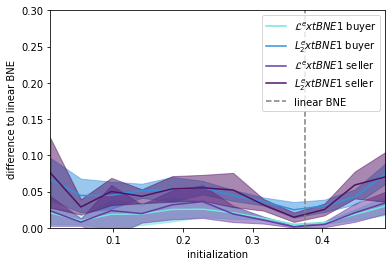

In [4]:
path = '/home/pieroth/bnelearn/experiments/debug/exp-3_experiment_10_seeds/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ["eval_vs_bne/epsilon_relative", "eval_vs_bne/L_2"]
metrics_names_latex = ["$\mathcal{L}^\text{BNE{1}}$", "$L_2^\text{BNE{1}}$"]
bidders = ['buyer', 'seller']
exp_names = sorted(os.listdir(path))
metrics = np.zeros((2, 2, len(metrics_names), len(exp_names)))

g_05s = np.zeros(len(exp_names))
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05s[i] = float(json.load(json_file)['setting']['pretrain_transform'])
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    # buyer
    for bidder_id in range(len(bidders)):
        for metric_id in range(len(metrics_names)):
            mean, std = get_value_and_std_from_df_entry(df[metrics_names_latex[metric_id]][bidder_id])
            metrics[bidder_id, 0, metric_id, i] = mean
            metrics[bidder_id, 1, metric_id, i] = std


metrics[metrics != metrics] = np.inf
colors = [['#6FE7DD', '#3490DE'],
          ['#6639A6', '#521262']]

plt.figure()
for bidder_id, bidder in enumerate(bidders):
    for metric_name_id, latex_metric_name in enumerate(metrics_names_latex):
        plt.plot(g_05s, metrics[bidder_id, 0, metric_name_id], label=latex_metric_name + ' ' + bidder, color=colors[bidder_id][metric_name_id])
        plt.fill_between(
            g_05s,
            metrics[bidder_id, 0, metric_name_id] - metrics[bidder_id, 1, metric_name_id],
            metrics[bidder_id, 0, metric_name_id] + metrics[bidder_id, 1, metric_name_id],
            alpha=0.5,
            color=colors[bidder_id][metric_name_id])
plt.plot([3./8., 3./8.], [0, 1], '--', color='grey', label=r'linear BNE')
plt.xlabel('initialization'); plt.ylabel('difference to linear BNE')
plt.xlim([g_05s[0], g_05s[-1]]); plt.ylim([0, .3])
plt.legend(loc='upper right')
plt.savefig(os.curdir + '/exp-3_figure.eps')
plt.show()

In [5]:
## EXP-3 custom pretraining experiments --------------------------------------
path = '/home/pieroth/bnelearn/experiments/debug/exp-3_experiment_10_seeds_only_pretraining/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss']
bne_ids = [1, 4]
metric_names_latex = []
for bne_id in bne_ids:
    metric_names_latex.extend(["$\mathcal{L}^\text{BNE{%s}}$" % str(bne_id), "$L_2^\text{BNE{%s}}$" % bne_id])

exp_names = sorted(os.listdir(path))
experiments = {}
df_list = []
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05 = float(json.load(json_file)['setting']['pretrain_transform'])
        g_05 = "{:.2f}".format(g_05)
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    df.insert(0, 'pretrain_transform', [g_05, None])
    df_list.append(df)
combined_df = pd.concat(df_list)
sliced_df = combined_df[metric_names_latex]

df_to_tex(sliced_df, name='exp-3_table_pretrain_transforms.tex',
        label='tab:exp-3_table_pretrain_transform',
        caption='Mean and standard deviation of experiments over ten runs' \
        + ' each for a different pretrained non-optimal Equilibrium.')